In [2]:
import random
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm
from IPython.display import display, clear_output
import math

from utils import test_agent, plot_stats

C:\Users\majda\anaconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\majda\anaconda3\envs\torch_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


C:\Users\majda\anaconda3\envs\torch_env\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


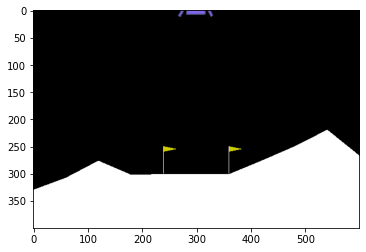

In [3]:
env = gym.make('LunarLander-v2')
env.reset()
plt.imshow(env.render(mode='rgb_array'))

In [4]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"CartPole env: State dimensions: {state_dims}, Number of actions: {num_actions}")

CartPole env: State dimensions: 8, Number of actions: 4


In [5]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.env._max_episode_steps = 200

    
    def reset(self):
        obs = self.env.reset()
        return torch.from_numpy(obs).unsqueeze(dim=0).float()
    
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [6]:
env = PreprocessEnv(env)

In [7]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)
print(f"Sample state: {state}")
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

Sample state: tensor([[-7.8583e-04,  1.3987e+00, -7.9599e-02, -5.4227e-01,  9.1724e-04,
          1.8030e-02,  0.0000e+00,  0.0000e+00]])
Next state: tensor([[-0.0016,  1.3859, -0.0795, -0.5679,  0.0018,  0.0178,  0.0000,  0.0000]]), Reward: tensor([[-1.3462]]), Done: tensor([[False]])


In [8]:
class DQN(nn.Module):

  def __init__(self, hidden_size, obs_size, n_actions):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(obs_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU()    
    )

    self.fc_adv = nn.Linear(hidden_size, n_actions) 
    self.fc_value = nn.Linear(hidden_size, 1)
  
  def forward(self, x):
    x = self.net(x.float())
    adv = self.fc_adv(x)
    value = self.fc_value(x)
    return value + adv - torch.mean(adv, dim=1, keepdim=True)

q_network = DQN(128, state_dims, num_actions)
target_q_network = copy.deepcopy(q_network).eval()

In [9]:
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

In [10]:
class ReplayMemory:
    
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

In [11]:
stats = {'MSE Loss': [], 'Returns': []}
def dueling_deep_q_learning(q_network, policy, episodes, 
                    alpha=0.0001, batch_size=512, gamma=0.99, epsilon = 0.2):    
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory()
   
    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        done = False
        ep_return = 0
        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            memory.insert([state, action, reward, done, next_state])
            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)              
                qsa_b = q_network(state_b).gather(1, action_b)
                
                next_qsa_b = target_q_network(next_state_b)
                next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]
                
                target_b = reward_b + ~done_b * gamma * next_qsa_b
                loss = F.mse_loss(qsa_b, target_b)
                q_network.zero_grad()
                loss.backward()
                optim.step()
                stats['MSE Loss'].append(loss.item())  
                
            state = next_state
            ep_return += reward.item()

        stats['Returns'].append(ep_return)
        if episode % 10 == 0:
            clear_output(wait=True)
            plot_stats(stats)
            target_q_network.load_state_dict(q_network.state_dict())

    return stats

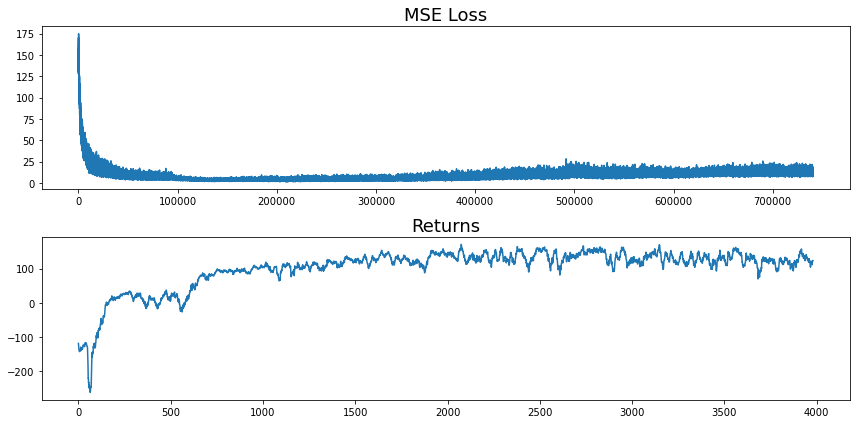

100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [3:34:50<00:00,  3.22s/it]


In [12]:
stats = dueling_deep_q_learning(q_network, policy, 4000, epsilon=0.25)

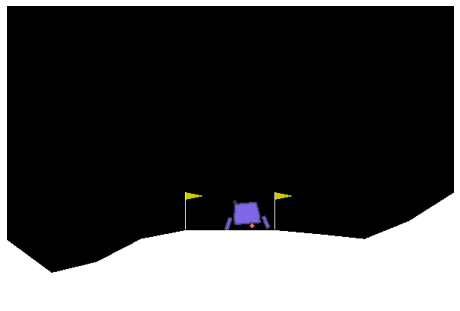

In [20]:
test_agent(env, policy, episodes=1)
env.close()

In [14]:
def save(model, path):
    torch.save(model.state_dict(), path)    

In [17]:
save(q_network,"models/dueling_deep_q_learning")